# PART Express On-time Performance Analysis
## Holiday Season
### November 3, 2020 - January 31, 2021

The following analysis was conducted using Automatic Passenger Count (APC) data from the PART Express system. On-time is defined as between 1 minute early and 5.5 minutes late. 

In [78]:
# import libraries
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import calplot
import matplotlib.pyplot as plt

pd.options.display.max_columns = 999

In [79]:
# define parameters
path = 'W:\!PART Express Data\APC Reports\On-Time Performance Report\OnTimePerformance_2020-11-03_2021-01-31(Holidays2020-2021).xlsx'
sheet = 'All Time Points'
engine = 'openpyxl'

# read in data
df = pd.read_excel(io=path, sheet_name=sheet, engine=engine)

# preview dataframe
df.head()

,DAYOFWK,ROUTE,BLOCK_NUM,DIR,TRIP_TIME,DATE,SERVICE_PERIOD,TP_NUM,TIMEPNT,ARRIVAL_TIME,DEPARTURE_TIME,DWDP_TIME,SCHEDULE_TIME,SCH_DEV,STATUS,LONGNAME
0,WKDY,4,94003,Dir = 1,11:10:00,2020-11-09,Off Peak,0,Ambulatory Care Center,11:05:51,11:10:48,11:11:02,11:10:00,1.03,On Time,4 - Alamance-Burlington Express
1,WKDY,4,94003,Dir = 1,11:10:00,2020-11-10,Off Peak,0,Ambulatory Care Center,11:10:19,11:10:27,11:10:40,11:10:00,0.67,On Time,4 - Alamance-Burlington Express
2,WKDY,4,94003,Dir = 1,11:10:00,2020-11-11,Off Peak,0,Ambulatory Care Center,11:05:28,11:07:31,11:08:33,11:10:00,-1.45,Early,4 - Alamance-Burlington Express
3,WKDY,4,94003,Dir = 1,11:10:00,2020-11-12,Off Peak,0,Ambulatory Care Center,11:04:04,11:09:26,11:10:21,11:10:00,0.35,On Time,4 - Alamance-Burlington Express
4,WKDY,4,94003,Dir = 1,11:10:00,2020-11-13,Off Peak,0,Ambulatory Care Center,11:04:31,11:09:42,11:10:15,11:10:00,0.25,On Time,4 - Alamance-Burlington Express


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46342 entries, 0 to 46341
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DAYOFWK         46342 non-null  object        
 1   ROUTE           46342 non-null  int64         
 2   BLOCK_NUM       46342 non-null  int64         
 3   DIR             46342 non-null  object        
 4   TRIP_TIME       46342 non-null  object        
 5   DATE            46342 non-null  datetime64[ns]
 6   SERVICE_PERIOD  46342 non-null  object        
 7   TP_NUM          46342 non-null  int64         
 8   TIMEPNT         46342 non-null  object        
 9   ARRIVAL_TIME    46342 non-null  object        
 10  DEPARTURE_TIME  46342 non-null  object        
 11  DWDP_TIME       46342 non-null  object        
 12  SCHEDULE_TIME   46342 non-null  object        
 13  SCH_DEV         46342 non-null  float64       
 14  STATUS          46342 non-null  object        
 15  LO

### Data cleaning

In [81]:
# create new attributes
df['Day of Week'] = df['DATE'].dt.day_name()
df['Month'] = df['DATE'].dt.month

# convert attributes to categories
df['DAYOFWK'] = df['DAYOFWK'].astype('category')
df['ROUTE'] = df['ROUTE'].astype('category')
df['DIR'] = df['DIR'].astype('category')
df['SERVICE_PERIOD'] = df['SERVICE_PERIOD'].astype('category')
df['TIMEPNT'] = df['TIMEPNT'].astype('category')
df['Day of Week'] = df['Day of Week'].astype('category')
df['Month'] = df['Month'].astype('category')

# check dataframe size
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46342 entries, 0 to 46341
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DAYOFWK         46342 non-null  category      
 1   ROUTE           46342 non-null  category      
 2   BLOCK_NUM       46342 non-null  int64         
 3   DIR             46342 non-null  category      
 4   TRIP_TIME       46342 non-null  object        
 5   DATE            46342 non-null  datetime64[ns]
 6   SERVICE_PERIOD  46342 non-null  category      
 7   TP_NUM          46342 non-null  int64         
 8   TIMEPNT         46342 non-null  category      
 9   ARRIVAL_TIME    46342 non-null  object        
 10  DEPARTURE_TIME  46342 non-null  object        
 11  DWDP_TIME       46342 non-null  object        
 12  SCHEDULE_TIME   46342 non-null  object        
 13  SCH_DEV         46342 non-null  float64       
 14  STATUS          46342 non-null  object        
 15  LO

In [82]:
# rename attributes
df.rename(columns={
    'DAYOFWK': 'Day Type',
    'BLOCK_NUM': 'Block ID',
    'DIR': 'Direction',
    'TRIP_TIME': 'Trip Start Time',
    'DATE': 'Date',
    'SERVICE_PERIOD': 'Service Period',
    'TP_NUM': 'Time Point Number',
    'TIMEPNT': 'Stop Name',
    'ARRIVAL_TIME': 'Arrival Time',
    'DEPARTURE_TIME': 'Departure Time',
    'SCHEDULE_TIME': 'Scheduled Time',
    'SCH_DEV': 'Schedule Deviation',
    'STATUS': 'Status',
    'LONGNAME': 'Route'
}, inplace=True)

# drop columns
df.drop(['ROUTE', 'DWDP_TIME'], axis=1, inplace=True)

# preview modified data set
df.head()

,Day Type,Block ID,Direction,Trip Start Time,Date,Service Period,Time Point Number,Stop Name,Arrival Time,Departure Time,Scheduled Time,Schedule Deviation,Status,Route,Day of Week,Month
0,WKDY,94003,Dir = 1,11:10:00,2020-11-09,Off Peak,0,Ambulatory Care Center,11:05:51,11:10:48,11:10:00,1.03,On Time,4 - Alamance-Burlington Express,Monday,11
1,WKDY,94003,Dir = 1,11:10:00,2020-11-10,Off Peak,0,Ambulatory Care Center,11:10:19,11:10:27,11:10:00,0.67,On Time,4 - Alamance-Burlington Express,Tuesday,11
2,WKDY,94003,Dir = 1,11:10:00,2020-11-11,Off Peak,0,Ambulatory Care Center,11:05:28,11:07:31,11:10:00,-1.45,Early,4 - Alamance-Burlington Express,Wednesday,11
3,WKDY,94003,Dir = 1,11:10:00,2020-11-12,Off Peak,0,Ambulatory Care Center,11:04:04,11:09:26,11:10:00,0.35,On Time,4 - Alamance-Burlington Express,Thursday,11
4,WKDY,94003,Dir = 1,11:10:00,2020-11-13,Off Peak,0,Ambulatory Care Center,11:04:31,11:09:42,11:10:00,0.25,On Time,4 - Alamance-Burlington Express,Friday,11


### Exploratory Data Analysis

Now that the data is clean, let's dig in and see what we can find out...

In [83]:
len_of_df = len(df)

by_route = df.groupby('Route').size().sort_values(ascending=False).to_frame()
by_route.rename(columns={0: 'Count'}, inplace=True)
by_route['Percentage'] = by_route['Count'] / len_of_df
by_route.style.format({'Count': '{:,}', 'Percentage': '{:.2%}'})

,Count,Percentage
Route,,
17 - Kernersville Express,"8,518",18.38%
2 - Greensboro Express,"5,073",10.95%
10 - Randolph Express,"4,873",10.52%
3 - High Point Express,"4,867",10.50%
1 - Winston-Salem Express,"4,842",10.45%
9 - Davidson Business 85 Express,"3,378",7.29%
4 - Alamance-Burlington Express,"2,866",6.18%
24 - Burgess/Regional Rd,"2,853",6.16%
20 - NW Pleasant Ridge,"2,578",5.56%


In [84]:
by_route.loc[[
    '1 - Winston-Salem Express', '2 - Greensboro Express', '3 - High Point Express'
]].style.format({'Count': '{:,}', 'Percentage': '{:.2%}'})

,Count,Percentage
Route,,
1 - Winston-Salem Express,"4,842",10.45%
2 - Greensboro Express,"5,073",10.95%
3 - High Point Express,"4,867",10.50%


The results appear to show that some routes are not being sampled as often as others. For example, Route 22 only has 600 observations in the data set while the other shuttle routes (20, 21, 23, 24) have around 2,500 records. The second data frame isolates the urban express routes (1, 2, 3) and they all have a similar number of observations. This is more in line with expectations as the operate the same number of trips.

In [85]:
df['Schedule Deviation'].describe()[['mean', 'std', 'min', 'max']]

mean     1.810029
std      3.235083
min     -9.980000
max     19.970000
Name: Schedule Deviation, dtype: float64

Looking at the overall system, the average deviation from the scheduled time is 1.81 minutes with a standard deviation of 3.24 minutes. The earliest a vehicle left was nearly 10 minutes early and the latest a vehicle arrived was almost 20 minutes late. It should be stated that vehicles arriving later than 20 minutes have been removed from the data on UTA's side. This is some logic that they utilize. Let's check out the minimum and maximum records...

In [86]:
# identify the stop with the latest departure
df.iloc[df['Schedule Deviation'].idxmax()].to_frame()

,26375
Day Type,WKDY
Block ID,202
Direction,Dir = 0
Trip Start Time,07:15:00
Date,2021-01-06 00:00:00
Service Period,AM Peak
Time Point Number,4
Stop Name,Four Seasons Mall
Arrival Time,07:44:58
Departure Time,07:44:58


The record with the largest schedule deviation is on Route 2 at the Four Seasons Mall. Let's dig into this a little bit...

In [87]:
df[
    (df['Block ID'] == 202) &
    (df['Date'] == '2021-01-06') &
    (df['Service Period'] == 'AM Peak')
].sort_values(by='Arrival Time')

,Day Type,Block ID,Direction,Trip Start Time,Date,Service Period,Time Point Number,Stop Name,Arrival Time,Departure Time,Scheduled Time,Schedule Deviation,Status,Route,Day of Week,Month
8159,WKDY,202,Dir = 0,06:15:00,2021-01-06,AM Peak,0,Greensboro Depot,06:34:01,06:34:01,06:15:00,19.02,Late,2 - Greensboro Express,Wednesday,1
572,WKDY,202,Dir = 1,06:45:00,2021-01-06,AM Peak,0,Coble Transportation Center,07:01:44,07:03:21,06:45:00,18.83,Late,2 - Greensboro Express,Wednesday,1
8374,WKDY,202,Dir = 0,07:15:00,2021-01-06,AM Peak,0,Greensboro Depot,07:28:21,07:30:48,07:15:00,16.33,Late,2 - Greensboro Express,Wednesday,1
26375,WKDY,202,Dir = 0,07:15:00,2021-01-06,AM Peak,4,Four Seasons Mall,07:44:58,07:44:58,07:25:00,19.97,Late,2 - Greensboro Express,Wednesday,1
1311,WKDY,202,Dir = 1,07:45:00,2021-01-06,AM Peak,0,Coble Transportation Center,07:56:33,07:59:02,07:45:00,14.50,Late,2 - Greensboro Express,Wednesday,1
8537,WKDY,202,Dir = 0,08:15:00,2021-01-06,AM Peak,0,Greensboro Depot,08:25:10,08:26:29,08:15:00,11.92,Late,2 - Greensboro Express,Wednesday,1
26484,WKDY,202,Dir = 0,08:15:00,2021-01-06,AM Peak,4,Four Seasons Mall,08:39:17,08:39:31,08:25:00,14.68,Late,2 - Greensboro Express,Wednesday,1
1924,WKDY,202,Dir = 1,08:45:00,2021-01-06,AM Peak,0,Coble Transportation Center,08:51:25,08:52:00,08:45:00,7.57,Late,2 - Greensboro Express,Wednesday,1
14819,WKDY,202,Dir = 1,08:45:00,2021-01-06,AM Peak,1,Four Seasons Mall,09:06:55,09:06:55,08:53:00,13.92,Late,2 - Greensboro Express,Wednesday,1


It appears that the vehicle got a late start first thing in the morning and remained behind all day. Will confirm using the TransLoc Instant Replay feature. The vehicle was late that morning. On TransLoc, the vehicle pulls into the Greensboro Depot around 6:30 AM so the APC data seems to be off by just a few minutes.

In [88]:
# identify the stop with the earliest departure
df.iloc[df['Schedule Deviation'].idxmin()].to_frame()

,37454
Day Type,WKDY
Block ID,1003
Direction,Dir = 1
Trip Start Time,16:30:00
Date,2020-12-11 00:00:00
Service Period,PM Peak
Time Point Number,6
Stop Name,North Asheboro Park & Ride
Arrival Time,17:06:01
Departure Time,17:06:01


In [89]:
df[
    (df['Block ID'] == 1003) &
    (df['Date'] == '2020-12-11') &
    (pd.to_datetime(df['Trip Start Time'], format='%H:%M:%S') == pd.to_datetime('16:30:00', format='%H:%M:%S'))
].sort_values(by='Arrival Time')

,Day Type,Block ID,Direction,Trip Start Time,Date,Service Period,Time Point Number,Stop Name,Arrival Time,Departure Time,Scheduled Time,Schedule Deviation,Status,Route,Day of Week,Month
9259,WKDY,1003,Dir = 1,16:30:00,2020-12-11,PM Peak,0,Greensboro Depot,16:26:13,16:29:09,16:30:00,0.33,On Time,10 - Randolph Express,Friday,12
18553,WKDY,1003,Dir = 1,16:30:00,2020-12-11,PM Peak,2,Gate City Blvd & Glenwood Ave,16:35:33,16:35:33,16:38:00,-2.45,Early,10 - Randolph Express,Friday,12
25656,WKDY,1003,Dir = 1,16:30:00,2020-12-11,PM Peak,4,Coliseum & Freeman Mill,16:40:35,16:40:35,16:42:00,-1.42,Early,10 - Randolph Express,Friday,12
35373,WKDY,1003,Dir = 1,16:30:00,2020-12-11,PM Peak,5,Randleman Park & Ride,16:56:58,16:56:58,17:02:00,-5.03,Early,10 - Randolph Express,Friday,12
37454,WKDY,1003,Dir = 1,16:30:00,2020-12-11,PM Peak,6,North Asheboro Park & Ride,17:06:01,17:06:01,17:16:00,-9.98,Early,10 - Randolph Express,Friday,12
40188,WKDY,1003,Dir = 1,16:30:00,2020-12-11,PM Peak,7,Randolph Health,17:21:43,17:21:43,17:21:00,0.72,On Time,10 - Randolph Express,Friday,12
44423,WKDY,1003,Dir = 1,16:30:00,2020-12-11,PM Peak,9,Randolph Community College,17:29:29,17:29:29,17:28:00,1.48,On Time,10 - Randolph Express,Friday,12


Looking at the table above, we can see that Route 10 left Greensboro on time. It passed the Gate City & Glenwood stop about two and half minutes early and continued to be early until it reached Asheboro at the Randolph Health stop. I will confirm that the vehicle pulled out of the N. Asheboro Park & Ride Lot early using the TransLoc Instant Replay feature...After watching the Instant Replay, the vehicle did arrive around 5:06 PM but did not leave until 5:16 PM. 

Now that we've examined the two extremes of the data set, let's take a look at the performance overall.

In [90]:
otp_performance = df.groupby('Status').size().sort_values().to_frame()
otp_performance.rename(columns={0: 'Count'}, inplace=True)
otp_performance['Percentage'] = otp_performance['Count'] / len_of_df
otp_performance.style.format({'Count': '{:,}', 'Percentage': '{:.2%}'})

,Count,Percentage
Status,,
Late,"5,230",11.29%
Early,"5,634",12.16%
On Time,"35,478",76.56%


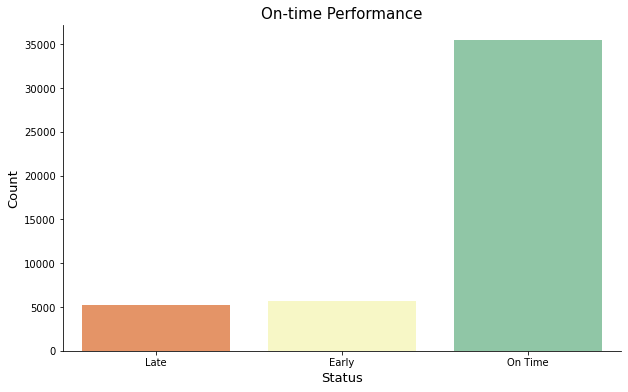

In [91]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x=otp_performance.index, y='Count', data=otp_performance, palette='Spectral')
plt.xlabel('Status',fontsize=13)
plt.ylabel('Count',fontsize=13)
plt.title('On-time Performance', fontsize=15)
sns.despine()
plt.show()

Looking at the entire data set, we can see that the majority of records are on-time. This represents about 76% on-time performance. The data set is evenly split between late and early. Let's examine how late or early PART Express vehicles are.

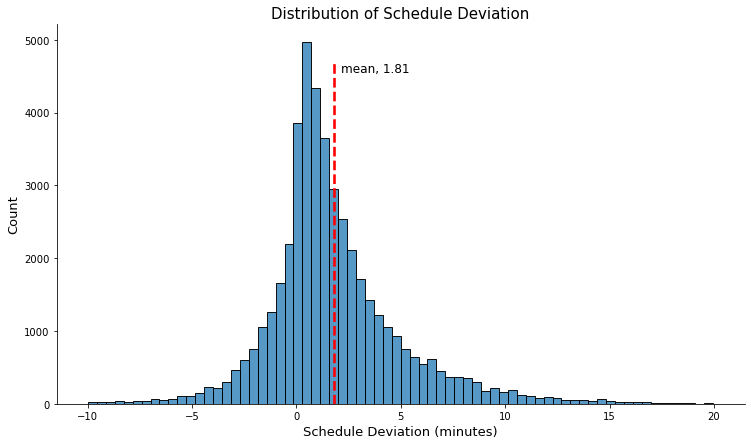

In [92]:
mean = round(df['Schedule Deviation'].mean(), 2)

# create histogram for schedule deviation
ax = sns.displot(df, x='Schedule Deviation', bins=70, height=6, aspect=1.75)
plt.axvline(mean, 0, 0.9, color='red', ls='--', lw=2.6)
plt.text(2.12, 4550, 'mean, ' + str(mean), size='large')
plt.xlabel('Schedule Deviation (minutes)',fontsize=13)
plt.ylabel('Count',fontsize=13)
plt.title('Distribution of Schedule Deviation', fontsize=15)
plt.show()

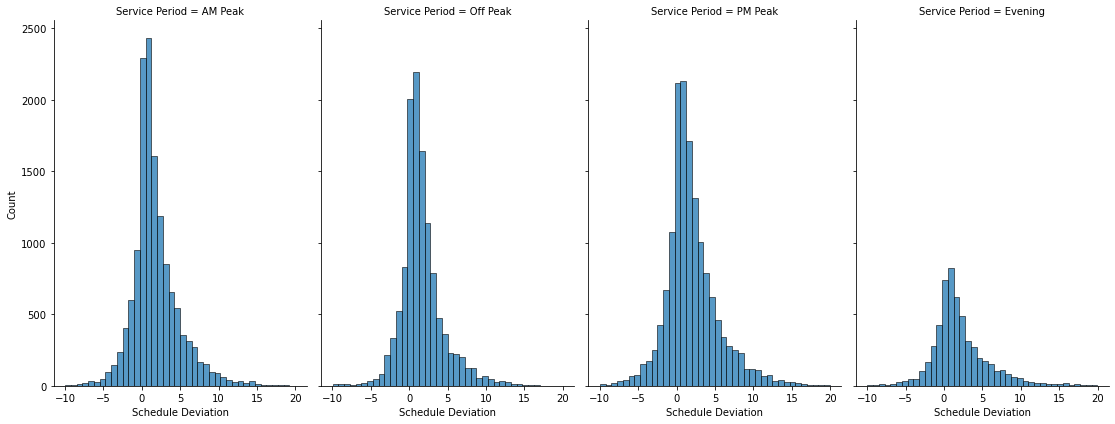

In [93]:
ax = sns.displot(
    df,
    x='Schedule Deviation',
    bins=40,
    col='Service Period',
    col_order=['AM Peak', 'Off Peak', 'PM Peak', 'Evening'],
    height=6,
    aspect=0.65
)

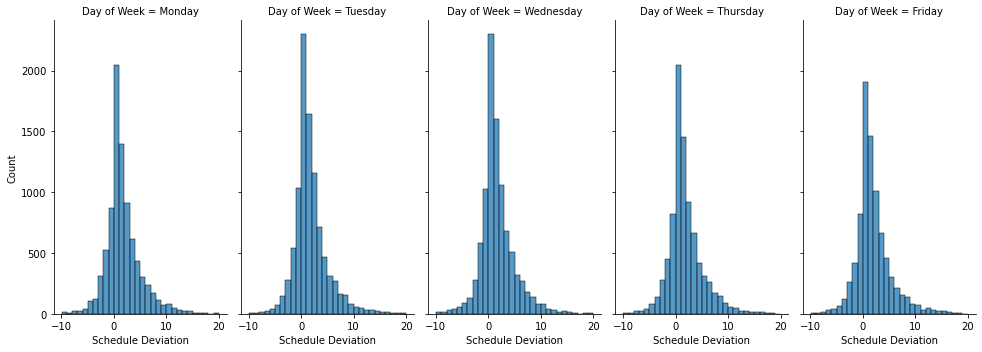

In [94]:
ax = sns.displot(
    df,
    x='Schedule Deviation',
    bins=30,
    col='Day of Week',
    col_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
    height=5,
    aspect=0.55
)

The distributions above all look pretty similar with the exception of Evening service. However, this can be explained by the Evening service period not having as much service as the other service periods. Let's look at how the individual routes have performed.


In [95]:
# get number of records by route
route1 = len(df[df['Route'] == '1 - Winston-Salem Express'])
route2 = len(df[df['Route'] == '2 - Greensboro Express'])
route3 = len(df[df['Route'] == '3 - High Point Express'])
route4 = len(df[df['Route'] == '4 - Alamance-Burlington Express'])
route6 = len(df[df['Route'] == '6 - Surry County Express'])
route9 = len(df[df['Route'] == '9 - Davidson Business 85 Express'])
route10 = len(df[df['Route'] == '10 - Randolph Express'])
route17 = len(df[df['Route'] == '17 - Kernersville Express'])
route20 = len(df[df['Route'] == '20 - NW Pleasant Ridge'])
route21 = len(df[df['Route'] == '21 - NE Chimney Rock'])
route22 = len(df[df['Route'] == '22 - SW Sandy Ridge'])
route23 = len(df[df['Route'] == '23 - SE Piedmont Parkway'])
route24 = len(df[df['Route'] == '24 - Burgess/Regional Rd'])

In [96]:
# breakdown status by route
status_by_route = pd.crosstab(
    index=df['Status'],
    columns=df['Route']
)

status_by_route['Route 1 Per'] = status_by_route['1 - Winston-Salem Express'] / route1
status_by_route['Route 2 Per'] = status_by_route['2 - Greensboro Express'] / route2
status_by_route['Route 3 Per'] = status_by_route['3 - High Point Express'] / route3
status_by_route['Route 4 Per'] = status_by_route['4 - Alamance-Burlington Express'] / route4
status_by_route['Route 6 Per'] = status_by_route['6 - Surry County Express'] / route6
status_by_route['Route 9 Per'] = status_by_route['9 - Davidson Business 85 Express'] / route9
status_by_route['Route 10 Per'] = status_by_route['10 - Randolph Express'] / route10
status_by_route['Route 17 Per'] = status_by_route['17 - Kernersville Express'] / route17
status_by_route['Route 20 Per'] = status_by_route['20 - NW Pleasant Ridge'] / route20
status_by_route['Route 21 Per'] = status_by_route['21 - NE Chimney Rock'] / route21
status_by_route['Route 22 Per'] = status_by_route['22 - SW Sandy Ridge'] / route22
status_by_route['Route 23 Per'] = status_by_route['23 - SE Piedmont Parkway'] / route23
status_by_route['Route 24 Per'] = status_by_route['24 - Burgess/Regional Rd'] / route24

# identify columns to keep
cols = [
    'Route 1 Per', 'Route 2 Per', 'Route 3 Per', 'Route 4 Per', 'Route 6 Per','Route 9 Per',
    'Route 10 Per','Route 17 Per','Route 20 Per', 'Route 21 Per', 'Route 22 Per', 'Route 23 Per',
    'Route 24 Per'
]

# select only columns of interest and transpose the dataframe
status_by_route = status_by_route[cols].transpose()[['On Time', 'Early', 'Late']]

# print out styled dataframe
status_by_route.style.format({
    'On Time': '{:.2%}', 'Early': '{:.2%}', 'Late': '{:.2%}'
})

Status,On Time,Early,Late
Route,,,
Route 1 Per,84.35%,0.85%,14.81%
Route 2 Per,66.80%,0.57%,32.62%
Route 3 Per,91.10%,4.21%,4.68%
Route 4 Per,74.42%,8.58%,16.99%
Route 6 Per,66.06%,16.44%,17.50%
Route 9 Per,64.77%,22.91%,12.31%
Route 10 Per,62.82%,19.76%,17.42%
Route 17 Per,79.34%,15.87%,4.79%
Route 20 Per,68.70%,29.56%,1.75%


We can see that the Urban express routes have mostly great on-time performance, except for Route 2. It appears to be late about 32% of the time. The Rural routes tend to be early quite often. However, looking back to the Route 10 example above, these routes may not be that early. Further analysis should be conducted. The shuttles, 21, 22, and 24 have exceptional on-time performance. Routes 20 and 23 are about 30% early. Again, this may be the result of faulty data and should be analyzed further.

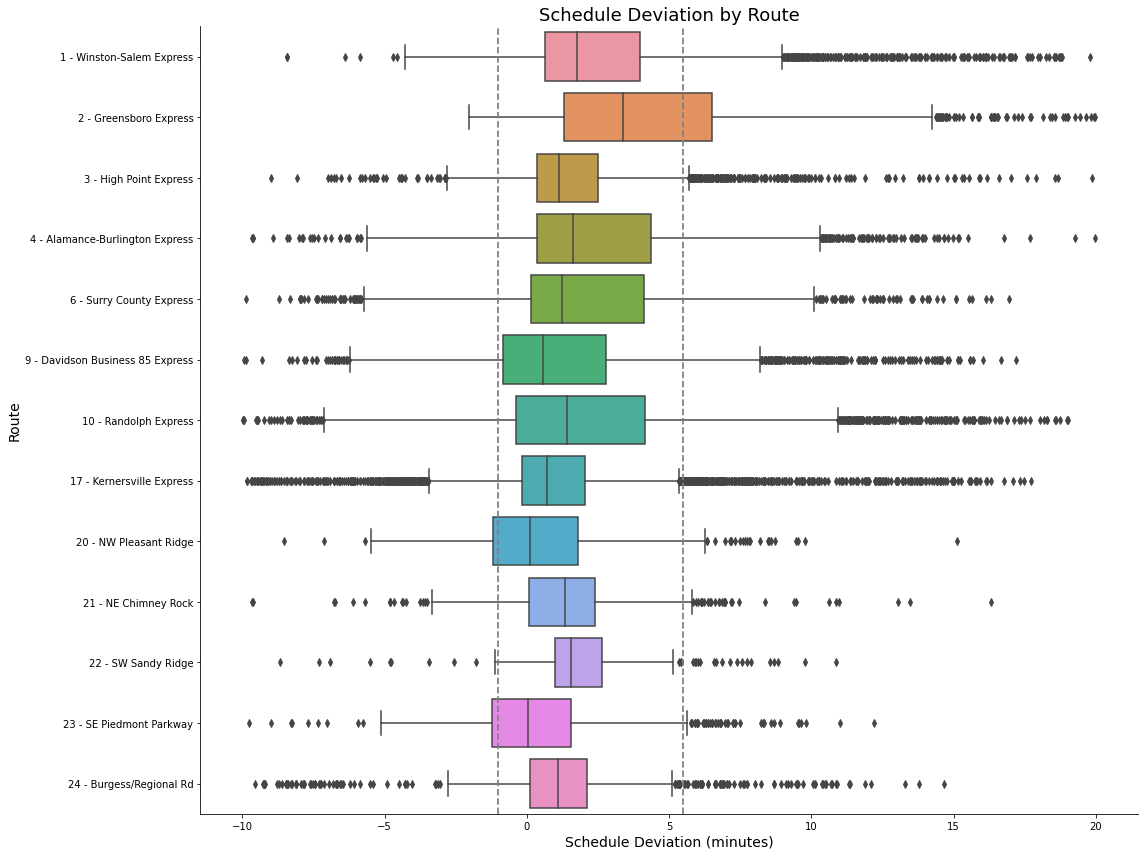

In [125]:
order = [
    '1 - Winston-Salem Express', '2 - Greensboro Express', '3 - High Point Express',
    '4 - Alamance-Burlington Express', '6 - Surry County Express',
    '9 - Davidson Business 85 Express', '10 - Randolph Express', 
    '17 - Kernersville Express', '20 - NW Pleasant Ridge', '21 - NE Chimney Rock',
    '22 - SW Sandy Ridge', '23 - SE Piedmont Parkway', '24 - Burgess/Regional Rd'
]

plt.figure(figsize=(16,12))
ax = sns.boxplot(x='Schedule Deviation', y='Route', data=df, order=order, orient='h')
plt.axvline(-1, 0, 1, color='gray', ls='--', lw=1.75)
plt.axvline(5.5, 0, 1, color='gray', ls='--', lw=1.75)
plt.title('Schedule Deviation by Route', fontsize=18)
plt.xlabel('Schedule Deviation (minutes)',fontsize=14)
plt.ylabel('Route',fontsize=14)
sns.despine()
plt.tight_layout()

Looking at the plot, Routes 20 and 23 appear to have the best average schedule deviation (mean closest to zero). Route 4 seems to have the widest range and Route 2 has the highest average deviation from the schedule. But overall, the routes appear to have a normal distribution in terms of deviation from the schedule. The two dashed vertical lines indicate the area that is considered on-time. We can see that the majority of the data falls within the bounds of the two lines.

In [98]:
sch_dev_mean = df.groupby('Route')['Schedule Deviation'].mean().to_frame()
sch_dev_std = df.groupby('Route')['Schedule Deviation'].std().to_frame()

sch_dev_perf = sch_dev_mean.merge(sch_dev_std, on='Route')
sch_dev_perf.rename(columns={
    'Schedule Deviation_x': 'Sch. Dev. Mean',
    'Schedule Deviation_y': 'Sch. Dev. Std'
}, inplace=True)
sch_dev_perf.sort_values('Sch. Dev. Mean', ascending=False).style.format({
    'Sch. Dev. Mean': '{:,.3f}', 'Sch. Dev. Std': '{:,.3f}'
})

,Sch. Dev. Mean,Sch. Dev. Std
Route,,
2 - Greensboro Express,4.212,3.475
1 - Winston-Salem Express,2.755,3.122
4 - Alamance-Burlington Express,2.444,3.393
10 - Randolph Express,2.035,4.197
6 - Surry County Express,1.987,4.032
22 - SW Sandy Ridge,1.919,1.736
3 - High Point Express,1.631,2.220
21 - NE Chimney Rock,1.357,1.994
9 - Davidson Business 85 Express,1.232,3.659


In [99]:
late_records = df[df['Status'] == 'Late']

top_10_late = late_records.groupby('Stop Name').size().sort_values(ascending=False)[:10].to_frame()
top_10_late.rename(columns={0: 'Count'}, inplace=True)
top_10_late.style.format({'Count': '{:,}'})

,Count
Stop Name,
Four Seasons Mall,"1,384"
Innovation Quarter,642
Coble Transportation Center,431
Greensboro Depot,363
Coliseum & Freeman Mill,200
Gate City Blvd & Glenwood Ave,170
North Asheboro Park & Ride,147
Winston-Salem Transportation Center,139
Randleman Park & Ride,136


It is now evident why Route 2 reported a lower than expected on-time performance. Almost 1,400 late observations occurred at Four Seasons Mall. Route 2 is the only route to serve this stop. One important note regarding this data, a few of the time points are published early which ensures passengers have enough time to make it to the stop before the bus arrives. Four Seasons Mall is such a stop. For example, one of the published time points for this stop is 6:25 AM. The bus may not arrive until 6:27 AM but by publishing the time as 6:25 AM, passengers will be sure to be at the stop by the time the bus arrives. Innovation Quarter is another example of this type of adjustment but for Route 1. What's interesting is that the mid-route time point for Route 3 is missing from this list which also has its time adjusted. Let's dig into the Four Seasons Mall data.

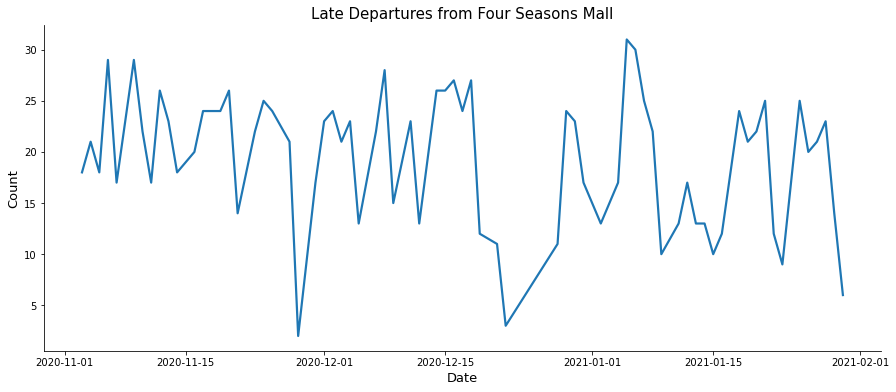

In [127]:
four_seasons_mall_late = late_records[late_records['Stop Name'] == 'Four Seasons Mall']

mall_late_by_date = four_seasons_mall_late.groupby('Date').size()

plt.figure(figsize=(15,6))
ax = sns.lineplot(data=mall_late_by_date, lw=2.2)
plt.xlabel('Date',fontsize=13)
plt.ylabel('Count',fontsize=13)
plt.title('Late Departures from Four Seasons Mall', fontsize=15)
sns.despine()
plt.show()

There doesn't appear to be any concentration of late records around a particular day. Let's now check by trip time.

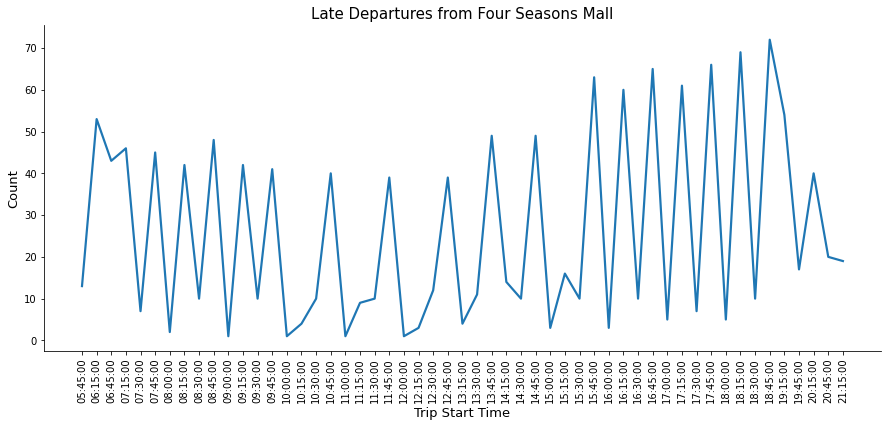

In [128]:
mall_late_by_trip = four_seasons_mall_late.groupby('Trip Start Time').size()
mall_late_by_trip.index.astype('string')

plt.figure(figsize=(15,6))
ax = sns.lineplot(data=mall_late_by_trip, lw=2.2)
plt.xlabel('Trip Start Time',fontsize=13)
plt.ylabel('Count',fontsize=13)
plt.title('Late Departures from Four Seasons Mall', fontsize=15)
plt.xticks(rotation = 90)
sns.despine()
plt.show()

This looks like an interesting plot. We see a series of high values followed by a steep drop. There appears to be a more consistent pattern during the AM Peak and PM Peak. Perhaps, the issue lies in a certain direction, for example, eastbound or westbound. Let's dig a little deeper...

In [102]:
mall_late_by_dir = four_seasons_mall_late.groupby('Direction').size()
mall_late_by_dir

Direction
Dir = 0     254
Dir = 1    1130
dtype: int64

On Route 2, Dir=1 equates to an outbound trip, or a trip leaving the Coble Transportation Center and heading east to the Greensboro Depot. Let's check out the distribution of schedule deviation for outbound trips at Four Seasons Mall for Route 2.

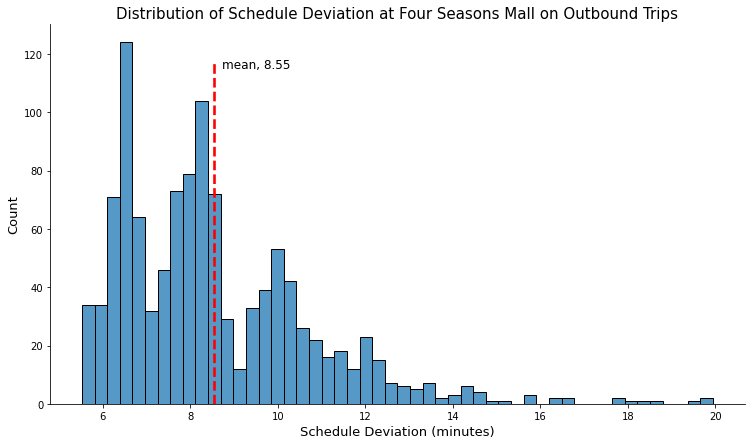

In [103]:
late_fourseasons_outbound = four_seasons_mall_late[four_seasons_mall_late['Direction'] == 'Dir = 1']
mean_outbound = round(late_fourseasons_outbound['Schedule Deviation'].mean(), 2)

# create histogram for schedule deviation
ax = sns.displot(late_fourseasons_outbound, x='Schedule Deviation', bins=50, height=6, aspect=1.75)
plt.axvline(mean_outbound, 0, 0.9, color='red', ls='--', lw=2.6)
plt.text(8.73, 115, 'mean, ' + str(mean_outbound), size='large')
plt.xlabel('Schedule Deviation (minutes)',fontsize=13)
plt.ylabel('Count',fontsize=13)
plt.title('Distribution of Schedule Deviation at Four Seasons Mall on Outbound Trips', fontsize=15)
plt.show()

It looks like a pretty heavily skewed distribution and that is causing the mean to be affected. Let me just highlight again that the scheduled time at this stop has been adjusted to ensure passengers are at the stop when the bus arrives. With the majority of observations being between 6 and 8 minutes, I'm not too concerned. If this was an issue, I imagine we would have customers calling about it. Let's check the median value, which is less affected by outliers in the data set.

In [104]:
round(late_fourseasons_outbound['Schedule Deviation'].median(), 2)

8.13

Wow! It's not that far off from the mean value. Maybe the outliers are not intense enough to pull the mean farther to the right. Since this stop is in the middle of the route and the data shows that the outbound trip tends to be late, let's check the start of line for inbound trips to see if they are departing on-time or late.

In [105]:
df[
    (df['Route'] == '2 - Greensboro Express') &
    (df['Direction'] == 'Dir = 0') &
    (df['Time Point Number'] == 0)
]['Status'].value_counts().to_frame()

,Status
On Time,1084
Late,194
Early,3


While there appears to be a large number of outbound trips that are being recorded as late at Four Seasons Mall, the dataframe above shows that the majority of inbound trips leaving the Greensboro Depot on Route 2 are on-time. 

Looking back in the data, we saw that Route 22 only had 600 observations. Let's dig into this and try and find out what is happening. Was data being collected up until a certain point or has the data collection be scattered through the period?

In [106]:
route22_by_date = df[df['Route'] == '22 - SW Sandy Ridge'].groupby('Date').size()

(<Figure size 900x244.8 with 3 Axes>,
 array([<AxesSubplot:ylabel='2020'>, <AxesSubplot:ylabel='2021'>],
       dtype=object))

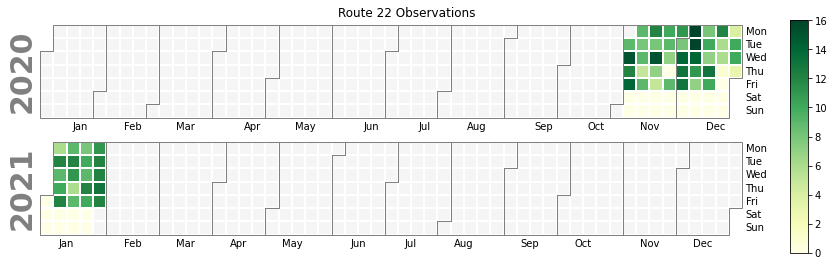

In [107]:
calplot.calplot(route22_by_date, edgecolor='gray', suptitle='Route 22 Observations', cmap='YlGn')

It looks like there are several days where the number of observations are low and other days where no observations were collected. Data is consistent throughout the analysis period. Let's examine one of the other shuttles for comparison.

In [108]:
route20_by_date = df[df['Route'] == '20 - NW Pleasant Ridge'].groupby('Date').size()

(<Figure size 900x244.8 with 3 Axes>,
 array([<AxesSubplot:ylabel='2020'>, <AxesSubplot:ylabel='2021'>],
       dtype=object))

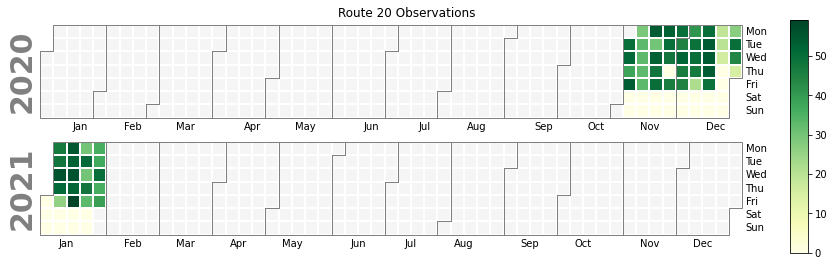

In [109]:
calplot.calplot(route20_by_date, edgecolor='gray', suptitle='Route 20 Observations', cmap='YlGn')

Right away, we can see a little more consistency in the data. Also, if we look at the scale bar, we can see that Route 20 has significantly more observations per day than Route 22. However, there are also some interesting patterns in this data. For example, the second to last week of December has lower observations. While there was no service on Christmas day, we did not run reduced service around the holidays. January started out with lots of data being collected by then trails off as the month goes on.

Back to the question at hand, while sparse, it appears that Route 22 has data for the entire analysis period. Let's try looking at the `Trip Start Time` column and see if only certain trips are being collected.

In [110]:
route22_by_trip = df[df['Route'] == '22 - SW Sandy Ridge'].groupby('Trip Start Time').size().to_frame()
route22_by_trip.rename(columns={0: 'Count'}, inplace=True)

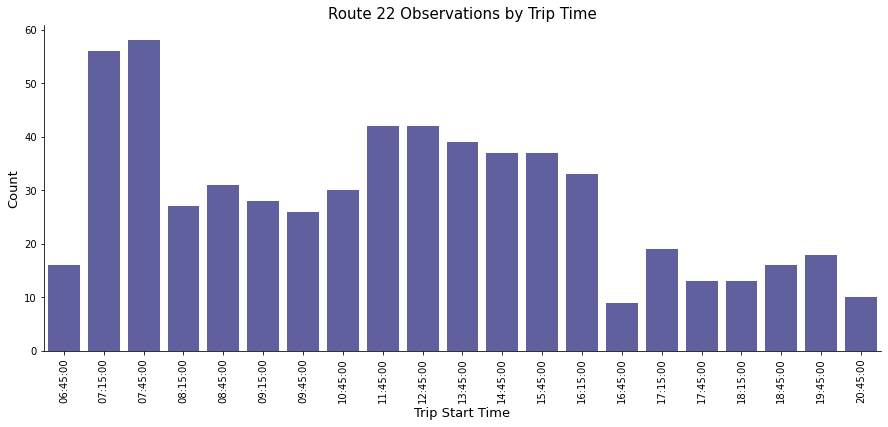

In [111]:
plt.figure(figsize=(15,6))
ax = sns.barplot(x=route22_by_trip.index, y='Count', data=route22_by_trip, color='blue', saturation=0.25)
plt.xlabel('Trip Start Time',fontsize=13)
plt.ylabel('Count',fontsize=13)
plt.title('Route 22 Observations by Trip Time', fontsize=15)
plt.xticks(rotation = 90)
sns.despine()
plt.show()

It appears that some trips are being collected more than others. For example, the 7:15 AM and the 7:45 AM trips both have more than 50 observations while the 4:45 PM and the 8:45 PM trips have around 10 observations. We may need to share this information with the APC vendor.

### Conclusion

Looking back, we can see that PART Express has an overall system on-time performance of approximately 76%. Let us keep in mind that a few of the time points are adjusted to ensure that passengers arrive to the bus stop with enough time. When we consider that factor and review the data presented above, we can be confident that the on-time performance is likely higher than the 76%. It also appears that we discovered some inconsistencies and irregularities in the data. This will need to be addressed with the APC vendor.